In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create the grid of inputs
def create_grid():
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    x_grid, y_grid = np.meshgrid(x, y)
    return x_grid, y_grid

# Create data for a given task
def create_task_data(a, b, task_id):
    x_grid, y_grid = create_grid()
    z_grid = np.sin(a * x_grid + b * y_grid)
    data = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    data = np.hstack([data, np.ones((data.shape[0], 1)) * task_id])
    targets = z_grid.ravel()
    return torch.Tensor(data), torch.Tensor(targets).unsqueeze(1)

# Train the model on a given task
def train_on_task(model, optimizer, criterion, data, targets, epochs=500):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluate the model on all tasks
def evaluate_on_tasks(model, tasks):
    model.eval()
    results = {}
    with torch.no_grad():
        for task_name, (data, targets) in tasks.items():
            outputs = model(data)
            mse = nn.MSELoss()(outputs, targets).item()
            results[task_name] = mse
        plt.show()
    return results

# Define tasks
tasks = {
    'Task 1': create_task_data(1, 1, 1),
    'Task 2': create_task_data(3, -2, 2),
    'Task 3': create_task_data(-4, 1, 3),
    'Task 4': create_task_data(1, 4, 4),
    'Task 5': create_task_data(-3, -3, 5)
}


In [89]:
def sample_data(data, targets, sample_size):
    indices = np.random.choice(data.shape[0], sample_size, replace=False)
    return data[indices], targets[indices]

In [91]:
from Scaled_KAN import FastKAN
# Initialize model, optimizer, and loss function
# model = FastKAN(layers_hidden=[2, 20, 1], grid_min=100)
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Train model continually and evaluate
all_results = {}

for task_name, (data, targets) in tasks.items():
    print(f"Training on {task_name}")   
    train_data = sample_data(data, targets, int(data.shape[0] * 0.8))
    train_on_task(model, optimizer, criterion, train_data[0], train_data[1], epochs=500)
    # test on the entire dataset
    results = evaluate_on_tasks(model, tasks)
    all_results[task_name] = results
    print(f"Results after {task_name}: {results}")

# Display final results
print("\nFinal Results:")
for task_name, results in all_results.items():
    print(f"After {task_name}: {results}")

Training on Task 1
Results after Task 1: {'Task 1': 0.0158455278724432, 'Task 2': 1.4418681859970093, 'Task 3': 2.14375638961792, 'Task 4': 3.039623498916626, 'Task 5': 4.138400554656982}
Training on Task 2
Results after Task 2: {'Task 1': 0.4614735245704651, 'Task 2': 0.43233251571655273, 'Task 3': 0.5359830260276794, 'Task 4': 0.6027255654335022, 'Task 5': 0.6948297023773193}
Training on Task 3
Results after Task 3: {'Task 1': 0.5650510787963867, 'Task 2': 0.5340444445610046, 'Task 3': 0.4388622045516968, 'Task 4': 0.5198675990104675, 'Task 5': 0.547272801399231}
Training on Task 4
Results after Task 4: {'Task 1': 0.9046258926391602, 'Task 2': 0.6770356297492981, 'Task 3': 0.5288508534431458, 'Task 4': 0.4281711280345917, 'Task 5': 0.5169867873191833}
Training on Task 5
Results after Task 5: {'Task 1': 1.1057080030441284, 'Task 2': 0.767484188079834, 'Task 3': 0.5804107785224915, 'Task 4': 0.4959685206413269, 'Task 5': 0.42568057775497437}

Final Results:
After Task 1: {'Task 1': 0.0

In [155]:
from kan import KAN
# Initialize model, optimizer, and loss function
model = KAN(width=[3,5,11,1], grid=3, k=2, sp_trainable=False, sb_trainable=False)
model.to('cuda')
# Train model continually and evaluate
all_results = {}
dataset = {}
for task_name, (data, targets) in tasks.items():
    print(f"Training on {task_name}")
    
    train_data = sample_data(data, targets, int(data.shape[0] * 0.8))
    print(train_data[0].shape, train_data[1].shape)
    #training the model
    dataset['train_input'] = torch.from_numpy(train_data[0].numpy()).to('cuda')
    dataset['train_label'] = torch.from_numpy(train_data[1].numpy()).to('cuda')
    dataset['test_input'] = torch.from_numpy(data.numpy()).to('cuda')
    dataset['test_label'] = torch.from_numpy(targets.numpy()).to('cuda')
    model.fit(dataset=dataset,opt='LBFGS', steps=40, update_grid=False)

    #testing the model
    mses = {}
    for task_name2, (data, targets) in tasks.items():
        data = torch.from_numpy(data.numpy()).to('cuda')
        targets = torch.from_numpy(targets.numpy()).to('cuda')
        results = model(data)#.detach().cpu().numpy()
        # targets = targets.cpu().numpy()
        mse = nn.MSELoss()(results, targets).item()
        mses[task_name2] = mse
    all_results[task_name] = mses
    print(f"Results after {task_name}: {mses}")

# Display final results
print("\nFinal Results:")
for task_name, results in all_results.items():
    print(f"After {task_name}: {results}")

checkpoint directory created: ./model
saving model version 0.0
Training on Task 1
torch.Size([8000, 3]) torch.Size([8000, 1])


description:   0%|                                                           | 0/40 [00:00<?, ?it/s]

| train_loss: 2.41e-01 | test_loss: 2.43e-01 | reg: 4.15e+01 | : 100%|█| 40/40 [00:10<00:00,  3.80it


saving model version 0.1
Results after Task 1: {'Task 1': 0.0592384859919548, 'Task 2': 5.777894496917725, 'Task 3': 6.676511764526367, 'Task 4': 4.6508636474609375, 'Task 5': 4.766806602478027}
Training on Task 2
torch.Size([8000, 3]) torch.Size([8000, 1])


| train_loss: 6.09e-01 | test_loss: 6.12e-01 | reg: 3.86e+01 | : 100%|█| 40/40 [00:10<00:00,  3.78it


saving model version 0.2
Results after Task 2: {'Task 1': 7.597165584564209, 'Task 2': 0.37395718693733215, 'Task 3': 3.516122579574585, 'Task 4': 3.7096452713012695, 'Task 5': 3.2263691425323486}
Training on Task 3
torch.Size([8000, 3]) torch.Size([8000, 1])


| train_loss: 6.24e-01 | test_loss: 6.27e-01 | reg: 3.43e+01 | : 100%|█| 40/40 [00:09<00:00,  4.15it


saving model version 0.3
Results after Task 3: {'Task 1': 9.867162704467773, 'Task 2': 4.744717597961426, 'Task 3': 0.39276358485221863, 'Task 4': 1.019981861114502, 'Task 5': 1.9314773082733154}
Training on Task 4
torch.Size([8000, 3]) torch.Size([8000, 1])


| train_loss: 6.34e-01 | test_loss: 6.40e-01 | reg: 4.22e+01 | : 100%|█| 40/40 [00:09<00:00,  4.14it


saving model version 0.4
Results after Task 4: {'Task 1': 21.734830856323242, 'Task 2': 15.280034065246582, 'Task 3': 5.486819267272949, 'Task 4': 0.40910810232162476, 'Task 5': 0.8982279896736145}
Training on Task 5
torch.Size([8000, 3]) torch.Size([8000, 1])


| train_loss: 6.73e-01 | test_loss: 6.73e-01 | reg: 4.55e+01 | : 100%|█| 40/40 [00:09<00:00,  4.30it

saving model version 0.5
Results after Task 5: {'Task 1': 19.463064193725586, 'Task 2': 17.57193946838379, 'Task 3': 12.31348705291748, 'Task 4': 3.654531955718994, 'Task 5': 0.45251885056495667}

Final Results:
After Task 1: {'Task 1': 0.0592384859919548, 'Task 2': 5.777894496917725, 'Task 3': 6.676511764526367, 'Task 4': 4.6508636474609375, 'Task 5': 4.766806602478027}
After Task 2: {'Task 1': 7.597165584564209, 'Task 2': 0.37395718693733215, 'Task 3': 3.516122579574585, 'Task 4': 3.7096452713012695, 'Task 5': 3.2263691425323486}
After Task 3: {'Task 1': 9.867162704467773, 'Task 2': 4.744717597961426, 'Task 3': 0.39276358485221863, 'Task 4': 1.019981861114502, 'Task 5': 1.9314773082733154}
After Task 4: {'Task 1': 21.734830856323242, 'Task 2': 15.280034065246582, 'Task 3': 5.486819267272949, 'Task 4': 0.40910810232162476, 'Task 5': 0.8982279896736145}
After Task 5: {'Task 1': 19.463064193725586, 'Task 2': 17.57193946838379, 'Task 3': 12.31348705291748, 'Task 4': 3.654531955718994, 'T

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)


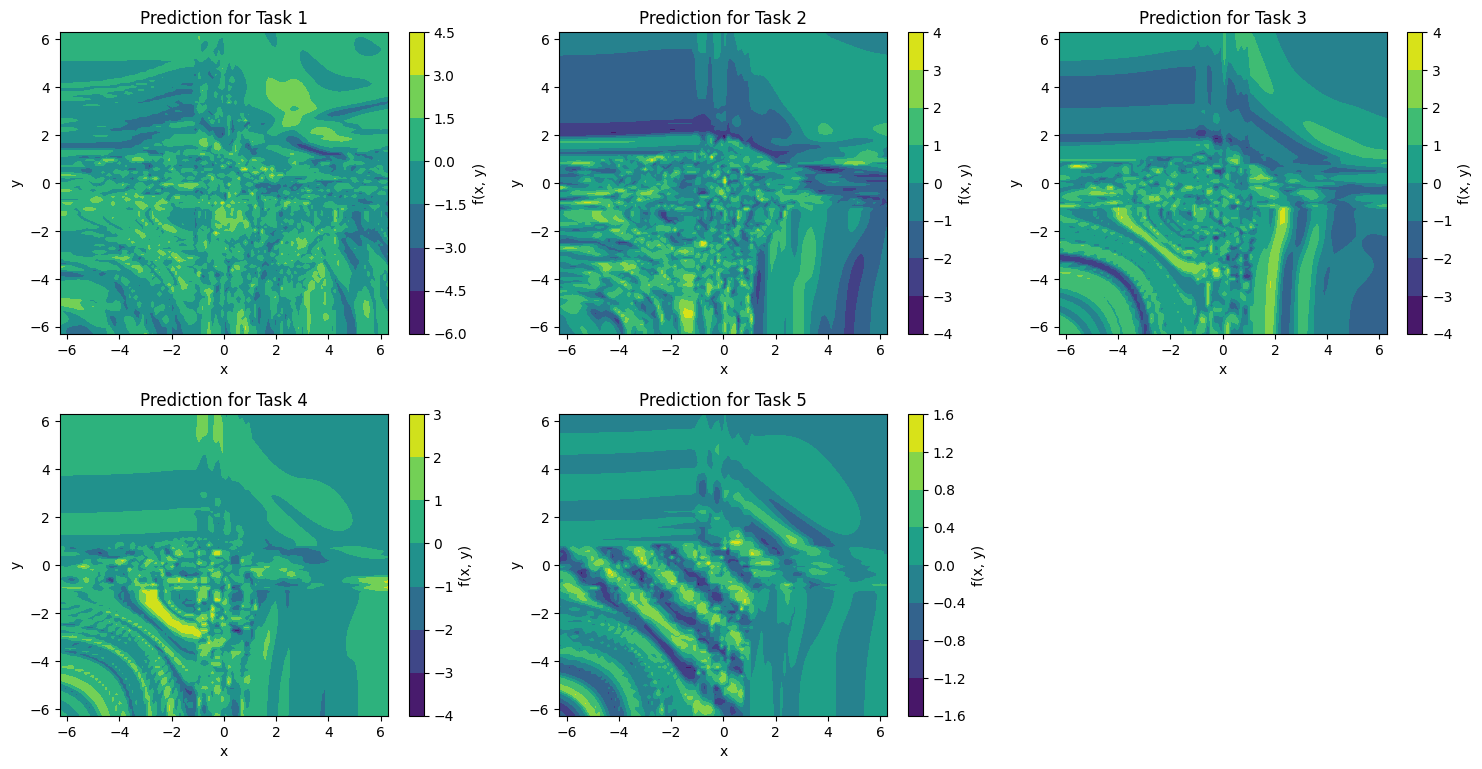

In [154]:
# Plot the final predictions for each task
x_grid, y_grid = create_grid()
data = torch.Tensor(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)

plt.figure(figsize=(15, 15))
for i, (task_name, (data, _)) in enumerate(tasks.items()):
    print(data[0][2])
    data = data.to('cuda')
    outputs = model(data).detach().cpu().numpy().reshape(x_grid.shape)
    plt.subplot(4, 3, i + 1)
    plt.contourf(x_grid, y_grid, outputs, cmap='viridis')
    plt.colorbar(label='f(x, y)')
    plt.title(f'Prediction for {task_name}')
    plt.xlabel('x')
    plt.ylabel('y')
plt.tight_layout()
plt.show()


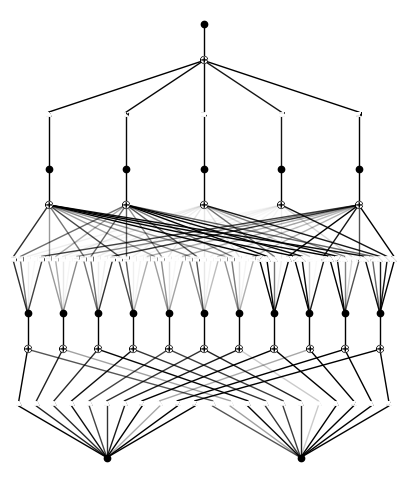

In [126]:
model.plot(beta=100)